# Data Processing

This codes replicates the method of data processing agent of the original paper "A Multi-Agent Approach for Personalised Hypertension Risk Prediction"

In [3]:
# Library used
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.stats import norm
import matplotlib.pyplot as plt

## Preprocessing
This comprises estimating missing data entries and removal of outliers
In the general population, blood pressure is known to exhibit a Gassian (normal) distribution pattern which makes Gaussian mixture models a suitable candidate for modelling blood pressure behaviour. For this study, we compute the missing records in the blood pressure historical data using Gaussian mixture regression (GMR) and identify outliers using Gaussian mixture models (GMM)
### Missing Data Estimation
This task is of utmost importance because most of the learning algorithms expect a continous time series to make accurate predictions, and the presence of missing values reduces the accuracy in the results
#### Identification of missing values
This is achieved by iterating through the received time series and comparing the timestamps associated with each record. Upon encountering non-consecutive time stamps, missing data and the intermediate data records are inserted into the time series with some initial value (Algorithm 1)

In [5]:
# Load and sort the data
data = pd.read_csv("C:/Users/m/OneDrive - The University of Melbourne/Documents/Learning/Research/WearableData/Mappings - All Data.csv")
print(data.shape)
print(data.head())

(18842, 9)
   UserID  Systolic  Diastolic  Heart Rate            Timestamp         DOB  \
0    9690     125.0       87.0        98.0  2018-05-16 11:00:00  1973-05-08   
1    9690     121.0       84.0        39.5  2018-05-16 12:00:00  1973-05-08   
2    9690     122.5       84.0        44.5  2018-05-16 13:00:00  1973-05-08   
3    9690     123.0       80.0        80.0  2018-05-16 14:00:00  1973-05-08   
4    9690     125.0       78.0        72.0  2018-05-16 15:00:00  1973-05-08   

   Weight  Height Gender  
0    96.0     177      M  
1    96.0     177      M  
2    96.0     177      M  
3    96.0     177      M  
4    96.0     177      M  


In [6]:
data["Timestamp"] = pd.to_datetime(data["Timestamp"]) #ensure timestamp is datetime
data = data.sort_values(by = ["UserID", "Timestamp"]).reset_index(drop = True)

# expected time interval is hourly
EXPECTED_INTERVAL = pd.Timedelta(hours = 1)

In [7]:
# Identify missing timestamps
missing_rows = []
for user_id, user_df  in data.groupby("UserID"):
    user_df = user_df.sort_values("Timestamp").reset_index(drop = True)
    for i in range(1, len(user_df)):
        current_time = user_df.loc[i, "Timestamp"]
        previous_time = user_df.loc[i - 1, "Timestamp"]
        time_diff = current_time - previous_time

        # If gap is larger than expected, it's missing data
        if time_diff > EXPECTED_INTERVAL:
            num_missing = int(time_diff/ EXPECTED_INTERVAL) - 1
            for j in range(1, num_missing + 1):
                 missing_time = previous_time + j * EXPECTED_INTERVAL
                 missing_rows.append({
                 "UserID": user_id,
                 "Timestamp": missing_time,
                 "Systolic": None,
                 "Diastolic": None,
                 "Heart Rate": None,
                 "IsMissing": True #create a dummy variable
                 })

#### Estimate values for the missing records using Gaussian mixture regression
We use Gaussian mixture regression to estimate the missing heart rate, systolic, and diastolic blood pressure values. A Gaussian distribution is modelled using the input data. A Gaussian mixture comprises several Gaussians, with each containing: a mean that defines the centre of the distribution and covariance that represents its width and weight that determines the size of the Gaussian function. (Algorithm 2)
The paper chooses GMR over simpler interpolation because biological signals like blood pressure are non-linear and multimodal. A patient might have stable periods and volatile periods; GMR can learn these distinct behaviours as separate Gaussian components, whereas a simple average would blur them together, loosing variance information.

In [8]:
# Insert missing records into the dataset
missing_df = pd.DataFrame(missing_rows)

# Mark existing data as non-missing
data["IsMissing"] = False

# Combine original and missing datasets
data_complete = pd.concat([data, missing_df], ignore_index = True)
data_complete = data_complete.sort_values(by = ["UserID", "Timestamp"]).reset_index(drop = True)
STATIC_COLS = ["DOB", "Weight", "Height", "Gender"] # those variables don't change over time
data_complete[STATIC_COLS] = (data_complete.groupby("UserID")[STATIC_COLS].transform(lambda x: x.ffill().bfill()))

C:\Users\m\AppData\Local\Temp\ipykernel_8320\2793902377.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_complete = pd.concat([data, missing_df], ignore_index = True)


In [9]:
data_complete.head(15)

,UserID,Systolic,Diastolic,Heart Rate,Timestamp,DOB,Weight,Height,Gender,IsMissing
0,9630,125.0,86.0,40.5,2018-04-23 13:00:00,1963-07-06,83.0,172.0,M,False
1,9630,125.5,84.0,46.0,2018-04-23 14:00:00,1963-07-06,83.0,172.0,M,False
2,9630,126.0,87.0,0.0,2018-04-23 15:00:00,1963-07-06,83.0,172.0,M,False
3,9630,123.0,86.5,54.5,2018-04-23 16:00:00,1963-07-06,83.0,172.0,M,False
4,9630,124.0,82.0,82.0,2018-04-23 17:00:00,1963-07-06,83.0,172.0,M,False
5,9630,108.4,73.4,0.0,2018-04-23 18:00:00,1963-07-06,83.0,172.0,M,False
6,9630,NaN,NaN,NaN,2018-04-23 19:00:00,1963-07-06,83.0,172.0,M,True
7,9630,NaN,NaN,NaN,2018-04-23 20:00:00,1963-07-06,83.0,172.0,M,True
8,9630,NaN,NaN,NaN,2018-04-23 21:00:00,1963-07-06,83.0,172.0,M,True
9,9630,NaN,NaN,NaN,2018-04-23 22:00:00,1963-07-06,83.0,172.0,M,True


In [10]:
data["UserID"].unique()

array([ 9630,  9690,  9888, 10049, 10412])

In [11]:
print(len(data_complete[data_complete["UserID"] == 10412]))
print(len(data_complete[data_complete["UserID"] == 10049]))
print(len(data_complete[data_complete["UserID"] == 9690]))
print(len(data_complete[data_complete["UserID"] == 9888]))
print(len(data_complete[data_complete["UserID"] == 9630]))

6059
7322
6046
5581
5804


In [12]:
# Check for user 9630
start_date = data[data["UserID"] == 9630]["Timestamp"].min()
end_date = data[data["UserID"] == 9630]["Timestamp"].max()
print(start_date)
print(end_date)
difference = end_date - start_date
total_hours = difference.total_seconds()/3600
print(f"Time difference: {difference}")
print(f"Total Hours: {total_hours}")
print(f"Total measurement: {total_hours + 1}")

# This indicates it should have 5803 entries

2018-04-23 13:00:00
2018-12-21 08:00:00
Time difference: 241 days 19:00:00
Total Hours: 5803.0
Total measurement: 5804.0


In [13]:
print(data_complete[data_complete["UserID"] == 9630])
data_complete.to_csv("complete_dataset.csv", index=False)

      UserID  Systolic  Diastolic  Heart Rate           Timestamp         DOB  \
0       9630     125.0       86.0        40.5 2018-04-23 13:00:00  1963-07-06   
1       9630     125.5       84.0        46.0 2018-04-23 14:00:00  1963-07-06   
2       9630     126.0       87.0         0.0 2018-04-23 15:00:00  1963-07-06   
3       9630     123.0       86.5        54.5 2018-04-23 16:00:00  1963-07-06   
4       9630     124.0       82.0        82.0 2018-04-23 17:00:00  1963-07-06   
...      ...       ...        ...         ...                 ...         ...   
5799    9630     126.0       78.0        75.0 2018-12-21 04:00:00  1963-07-06   
5800    9630     123.0       80.0        78.0 2018-12-21 05:00:00  1963-07-06   
5801    9630     120.0       79.0        78.0 2018-12-21 06:00:00  1963-07-06   
5802    9630     126.0       78.0        74.0 2018-12-21 07:00:00  1963-07-06   
5803    9630     118.0       79.0        75.0 2018-12-21 08:00:00  1963-07-06   

      Weight  Height Gender

In [14]:
# # Apply Gaussian Mixture Regression
# # Try with a specific user (9630) to start
# user_data = data_complete[data_complete["UserID"] == 9630].copy()
# user_data = user_data.set_index("Timestamp")

In [15]:
# def conditional_mean(mu, Sigma, obs_idx, miss_idx, x_obs, reg=1e-6):
#     """ Calculate the conditional mean for a single GMM component"""
#     mu_o = mu[obs_idx]
#     mu_m = mu[miss_idx]

#     Sigma_oo = Sigma[np.ix_(obs_idx, obs_idx)]
#     Sigma_mo = Sigma[np.ix_(miss_idx, obs_idx)]

#     Sigma_oo = Sigma_oo + reg * np.eye(len(obs_idx))
#     inv_Sigma_oo = np.linalg.inv(Sigma_oo)

#     return mu_m + Sigma_mo @ inv_Sigma_oo @ (x_obs - mu_o)

# # GMR imputation for one user
# def impute_user_gmr(user_df, signal_cols, buffer_size = 300, n_components = 4, min_buffer_rows = 20, reg_covar = 1e-6, random_state = 0):
#     user_df = user_df.sort_values("Timestamp").reset_index(drop=True)
#     for t in range(len(user_df)):
#         row = user_df.loc[t, signal_cols]

#         if row.isnull().any():
#             buffer_start = max(0, t - buffer_size)
#             buffer = user_df.loc[buffer_start:t-1, signal_cols].dropna()

#             if len(buffer) < min_buffer_rows:
#                 # fallback: mean of buffer or global mean
#                 for col in signal_cols:
#                     if pd.isna(user_df.at[t, col]):
#                         user_df.at[t, col] = buffer[col].mean()
#                 continue

#             X = buffer.values

#             gmm = GaussianMixture(
#                 n_components=n_components,
#                 covariance_type="full",
#                 reg_covar=reg_covar,
#                 random_state=random_state,
#                 max_iter=200
#             )
#             gmm.fit(X)

#             obs_idx = [i for i, c in enumerate(signal_cols) if not pd.isna(row[c])]
#             miss_idx = [i for i, c in enumerate(signal_cols) if pd.isna(row[c])]

#             # If all missing → use global GMM mean
#             if len(obs_idx) == 0:
#                 global_mean = np.average(gmm.means_, axis=0, weights=gmm.weights_)
#                 for i in miss_idx:
#                     user_df.at[t, signal_cols[i]] = global_mean[i]
#                 continue

#             x_obs = row.iloc[obs_idx].values

#             numerators = []
#             cond_means = []

#             for k in range(gmm.n_components):
#                 mu_k = gmm.means_[k]
#                 Sigma_k = gmm.covariances_[k]

#                 # p(x_obs | k)
#                 mu_o = mu_k[obs_idx]
#                 Sigma_oo = Sigma_k[np.ix_(obs_idx, obs_idx)] + reg_covar * np.eye(len(obs_idx))

#                 try:
#                     p_x = multivariate_normal.pdf(x_obs, mu_o, Sigma_oo)
#                 except Exception:
#                     p_x = 0.0

#                 numerators.append(gmm.weights_[k] * p_x)

#                 cm = conditional_mean(
#                     mu_k, Sigma_k, obs_idx, miss_idx, x_obs, reg=reg_covar
#                 )
#                 cond_means.append(cm)

#             numerators = np.array(numerators)
#             denom = numerators.sum()

#             if denom == 0:
#                 for i in miss_idx:
#                     user_df.at[t, signal_cols[i]] = buffer[signal_cols[i]].mean()
#                 continue

#             weights_post = numerators / denom
#             cond_means = np.vstack(cond_means)
#             x_miss_hat = weights_post @ cond_means
#             for j, i in enumerate(miss_idx):
#                 user_df.at[t, signal_cols[i]] = x_miss_hat[j]
#     return user_df

# # Apply GMR imputation to full dataset (per user)
# def gmr_impute_dataset(df):
#     signal_cols = ["Systolic", "Diastolic", "Heart Rate"]

#     df = df.copy()
#     df["Timestamp"] = pd.to_datetime(df["Timestamp"])

#     imputed_users = []

#     for user_id, user_df in df.groupby("UserID"):
#         user_imputed = impute_user_gmr(
#             user_df,
#             signal_cols=signal_cols,
#             buffer_size=300,      # ~12 days of hourly data
#             n_components=4,       # paper uses small K
#             min_buffer_rows=20
#         )
#         imputed_users.append(user_imputed)

#     return pd.concat(imputed_users).sort_values(["UserID", "Timestamp"])

In [16]:
# # Run it on the complete dataset
# df_impute = gmr_impute_dataset(data_complete)
# df_imputed.to_csv("dataset_after_gmr_imputation.csv", index=False)

In [17]:
data.isna().sum()

UserID        0
Systolic      0
Diastolic     0
Heart Rate    0
Timestamp     0
DOB           0
Weight        0
Height        0
Gender        0
IsMissing     0
dtype: int64

In [18]:
df = data.copy()

# Timestamp → hour, day
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Hour"] = df["Timestamp"].dt.hour
df["DayOfWeek"] = df["Timestamp"].dt.dayofweek

# Age from DOB
df["DOB"] = pd.to_datetime(df["DOB"])
df["Age"] = (df["Timestamp"] - df["DOB"]).dt.days / 365

# Encode Gender
df["GenderEncoded"] = df["Gender"].map({"M": 0, "F": 1})

In [19]:
Y_cols = ["Systolic", "Diastolic", "Heart Rate"]
X_cols = ["Hour", "DayOfWeek", "Age", "Weight", "Height", "GenderEncoded"]

In [20]:
X_train = df[X_cols + Y_cols].values

bic_scores = []
K_range = range(1, 20)

for k in K_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(X_train)
    bic_scores.append(gmm.bic(X_train))

best_k = K_range[np.argmin(bic_scores)]
print("Best K =", best_k)

gmm = GaussianMixture(
    n_components=best_k,
    covariance_type="full",
    random_state=42
)
gmm.fit(X_train)

Best K = 19


GaussianMixture(n_components=19, random_state=42)

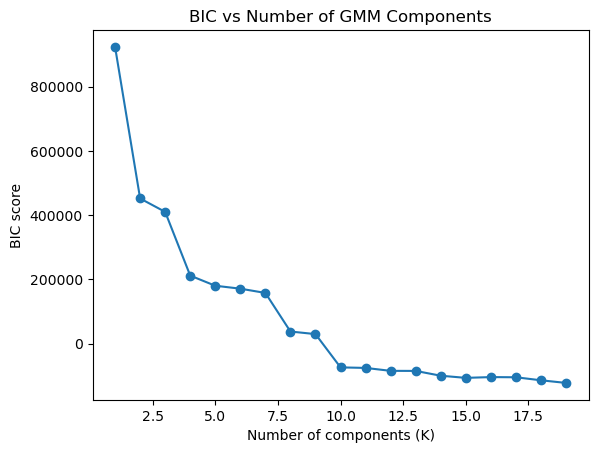

In [21]:
# ===== Plot =====
plt.figure()
plt.plot(K_range, bic_scores, marker='o')
plt.xlabel("Number of components (K)")
plt.ylabel("BIC score")
plt.title("BIC vs Number of GMM Components")
plt.show()

In [22]:
gmm = GaussianMixture(
        n_components=best_k,
        covariance_type="full",
        random_state=42
    )
gmm.fit(X_train)

GaussianMixture(n_components=19, random_state=42)

In [23]:
def multivariate_gaussian(x, mean, cov):
    d = len(mean)
    cov_inv = np.linalg.pinv(cov)
    diff = x - mean
    exponent = -0.5 * diff @ cov_inv @ diff.T
    denom = np.sqrt((2 * np.pi) ** d * np.linalg.det(cov) + 1e-9)
    return np.exp(exponent) / denom

In [3]:
def gmr_impute(row, gmm, X_cols, Y_cols):
    """ This function implements Gaussian Mixture Regression (GMR) for imputing missing values
     - Row: A data row containing observed values
     - X_cols: Column names of observed variables
     - Y_cols: Column names of variable to be imputed """
    x = row[X_cols].values.reshape(1, -1)

    d_x = len(X_cols)
    means = gmm.means_
    covs = gmm.covariances_
    weights = gmm.weights_

    y_preds = []
    responsibilities = []

    for k in range(gmm.n_components):
        mu_x = means[k][:d_x]
        mu_y = means[k][d_x:]

        sigma_xx = covs[k][:d_x, :d_x]
        sigma_yx = covs[k][d_x:, :d_x]

        sigma_xx_inv = np.linalg.pinv(sigma_xx)
        y_k = mu_y + sigma_yx @ sigma_xx_inv @ (x - mu_x).T

        y_preds.append(y_k.flatten())

        resp = weights[k] * multivariate_gaussian(
            x.flatten(), mu_x, sigma_xx
        )
        responsibilities.append(resp)

    responsibilities = np.array(responsibilities)
    responsibilities /= responsibilities.sum()

    y_hat = np.sum(
        responsibilities[:, None] * np.array(y_preds),
        axis=0
    )

    return y_hat.flatten()


In [25]:
df_filled = data_complete.copy()

# Timestamp → hour, day
df_filled["Timestamp"] = pd.to_datetime(df_filled["Timestamp"])
df_filled["Hour"] = df_filled["Timestamp"].dt.hour
df_filled["DayOfWeek"] = df_filled["Timestamp"].dt.dayofweek

# Age from DOB
df_filled["DOB"] = pd.to_datetime(df_filled["DOB"])
df_filled["Age"] = (df_filled["Timestamp"] - df_filled["DOB"]).dt.days / 365

# Encode Gender
df_filled["GenderEncoded"] = df_filled["Gender"].map({"M": 0, "F": 1})

missing_mask = df_filled["IsMissing"] == True

for idx, row in df_filled[missing_mask].iterrows():
    y_hat = gmr_impute(row, gmm, X_cols, Y_cols)
    df_filled.loc[idx, Y_cols] = y_hat[-3:]
    print(f"{idx}/{len(df_filled)}")

6/30812
7/30812
8/30812
9/30812
10/30812
11/30812
12/30812
13/30812
14/30812
15/30812
16/30812
17/30812
30/30812
31/30812
32/30812
33/30812
34/30812
35/30812
36/30812
37/30812
38/30812
39/30812
40/30812
41/30812
52/30812
53/30812
54/30812
55/30812
56/30812
57/30812
58/30812
59/30812
60/30812
61/30812
62/30812
63/30812
64/30812
65/30812
66/30812
67/30812
68/30812
69/30812
70/30812
71/30812
72/30812
73/30812
74/30812
75/30812
76/30812
77/30812
78/30812
79/30812
80/30812
81/30812
82/30812
83/30812
84/30812
85/30812
86/30812
87/30812
88/30812
89/30812
90/30812
91/30812
92/30812
93/30812
94/30812
95/30812
96/30812
97/30812
98/30812
99/30812
100/30812
101/30812
102/30812
103/30812
104/30812
105/30812
106/30812
107/30812
108/30812
109/30812
110/30812
111/30812
112/30812
113/30812
114/30812
115/30812
116/30812
117/30812
118/30812
119/30812
120/30812
121/30812
139/30812
140/30812
141/30812
142/30812
143/30812
144/30812
145/30812
146/30812
147/30812
148/30812
149/30812
150/30812
151/30812
152/30

In [26]:
df_filled.head(20)

,UserID,Systolic,Diastolic,Heart Rate,Timestamp,DOB,Weight,Height,Gender,IsMissing,Hour,DayOfWeek,Age,GenderEncoded
0,9630,125.000000,86.000000,40.500000,2018-04-23 13:00:00,1963-07-06,83.0,172.0,M,False,13,0,54.835616,0
1,9630,125.500000,84.000000,46.000000,2018-04-23 14:00:00,1963-07-06,83.0,172.0,M,False,14,0,54.835616,0
2,9630,126.000000,87.000000,0.000000,2018-04-23 15:00:00,1963-07-06,83.0,172.0,M,False,15,0,54.835616,0
3,9630,123.000000,86.500000,54.500000,2018-04-23 16:00:00,1963-07-06,83.0,172.0,M,False,16,0,54.835616,0
4,9630,124.000000,82.000000,82.000000,2018-04-23 17:00:00,1963-07-06,83.0,172.0,M,False,17,0,54.835616,0
5,9630,108.400000,73.400000,0.000000,2018-04-23 18:00:00,1963-07-06,83.0,172.0,M,False,18,0,54.835616,0
6,9630,119.750407,81.553982,82.205720,2018-04-23 19:00:00,1963-07-06,83.0,172.0,M,True,19,0,54.835616,0
7,9630,119.732295,81.399782,82.385918,2018-04-23 20:00:00,1963-07-06,83.0,172.0,M,True,20,0,54.835616,0
8,9630,119.717048,81.249570,82.448080,2018-04-23 21:00:00,1963-07-06,83.0,172.0,M,True,21,0,54.835616,0
9,9630,119.711623,81.111115,82.406538,2018-04-23 22:00:00,1963-07-06,83.0,172.0,M,True,22,0,54.835616,0


In [27]:
df_filled.to_csv("dataset_after_gmr_imputation.csv", index=False)

In [ ]:
# FEATURES = ["Systolic", "Diastolic", "Heart Rate"]
# WINDOW_SIZE = 24 # a window size of 24 is general choice as this is one circadian cycle
# N_COMPONENTS = 3 # Number of Gaussian components

# # Build sliding buffer

# def build_sliding_window(df, idx, window_size):
#     start = max(0, idx - window_size)
#     window = df.iloc[start:idx][FEATURES]
#     return window.dropna()

# def gmr_impute(gmm, x_obs, obs_idx, miss_idx):
#     """ The missing value is generated using the regression function m(x)"""
#     weights = gmm.weights_
#     means = gmm.means_
#     covs = gmm.covariances_

#     x_obs = x_obs.reshape(-1, 1)

#     conditional_means = []
#     responsibilities = []

#     for k in range(gmm.n_components):
#         mu = means[k]
#         Sigma = covs[k]

#         mu_o = mu[obs_idx].reshape(-1, 1)
#         mu_m = mu[miss_idx].reshape(-1, 1)

#         Sigma_oo = Sigma[np.ix_(obs_idx, obs_idx)]
#         Sigma_mo = Sigma[np.ix_(miss_idx, obs_idx)]

#         # Conditional mean
#         mu_cond = mu_m + Sigma_mo @ np.linalg.inv(Sigma_oo) @ (x_obs - mu_o)

#         conditional_means.append(mu_cond)

#         # Responsibility (beta_k)
#         resp = weights[k]
#         responsibilities.append(resp)

#     responsibilities = np.array(responsibilities)
#     responsibilities /= responsibilities.sum()

#     imputed = sum(
#         responsibilities[k] * conditional_means[k]
#         for k in range(gmm.n_components)
#     )

#     return imputed.flatten()

In [ ]:
# # Apply GMR per user
# df_imputed = data_complete.copy()
# for user_id, user_df in df_imputed.groupby('UserID'):
#     user_df = user_df.reset_index()

#     for i, row in user_df.iterrows():

#         if not row['IsMissing']:
#             continue

#         Wp = build_sliding_window(user_df, i, WINDOW_SIZE)

#         # Need enough data to fit GMM
#         if len(Wp) < N_COMPONENTS:
#             continue

#         gmm = GaussianMixture(
#             n_components=N_COMPONENTS,
#             covariance_type='full',
#             random_state=42
#         )
#         gmm.fit(Wp.values)

#         # Observed / missing indices
#         obs_idx = np.where(~row[FEATURES].isna())[0]
#         miss_idx = np.where(row[FEATURES].isna())[0]

#         if len(obs_idx) == 0:
#             continue

#         x_obs = row[FEATURES].iloc[obs_idx].values

#         imputed_values = gmr_impute(
#             gmm,
#             x_obs,
#             obs_idx,
#             miss_idx
#         )

#         # Write back
#         for j, col_idx in enumerate(miss_idx):
#             col = FEATURES[col_idx]
#             df_imputed.loc[
#                 (df_imputed['UserID'] == user_id) &
#                 (df_imputed['Timestamp'] == row['Timestamp']),
#                 col
#             ] = imputed_values[j]

In [ ]:
# print(df_imputed[FEATURES].isna().sum())
# print(data_complete[FEATURES].isna().sum())